In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions
from similarity_measure import SimilarityMeasures
import MS_similarity_classical as MS_sim_classic
import plotting_functions

In [2]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minmax_10_1000_2dec_exp08_191116.json")
file_mgf = os.path.join(PATH_MS_DATA, "MS-MS_spectra_GNPS_cleaned_positive_mode_spectra_uniqueInchikey_subset.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.0,
                                                           exp_intensity_filter = 0.8,
                                                           min_keep_peaks_0 = 10,
                                                           min_keep_peaks_per_mz = 20/200,
                                                           min_peaks = 10,
                                                           max_peaks = 1000, #None, #500,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [3]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


In [4]:
MS_library = SimilarityMeasures(MS_documents, MS_documents_intensity)
MS_library.preprocess_documents(1, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_library.dictionary))

Preprocess documents...
Number of unique words:  116344


In [6]:
file_model_word2vec = os.path.join(PATH_SAVE_MODEL, 'S2V_uniqueInchikey_pos_d300_w500_neg5_minmax10_1000_dec2_exp08_iter15.model')
MS_library.build_model_word2vec(file_model_word2vec, sg=0, negative=5, size=300, window=500, 
                             min_count=1, workers=4, iterations= [15], 
                             use_stored_model=True)

Load stored word2vec model ...


## Load Spec2Vec similarity scores

In [8]:
M_sim_ctr = np.load(os.path.join(PATH_COMPUTED, 'M_sim_spec2vec_uniqueInchikeys.npy'))

## Load similarities based on molecular fingerprints

In [21]:
filename = os.path.join(PATH_COMPUTED, 'M_sim_mol_uniqueInchikey_rdkit2048_jaccard.npy')
M_mol_sim_rdkit = MS_sim_classic.mol_sim_matrix([],
                                                [],
                                                method = 'jaccard',
                                                filename = filename)

Molecular similarity scores found and loaded.


In [22]:
M_mol_sim_rdkit.shape

(10998, 10998)

In [ ]:
# pass on IDs for which fingerprint could not be calculated:
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

## Load modified cosine similarities

In [13]:
filename = PATH_COMPUTED + 'M_sim_modcos_uniqueInchikey_modcos_200217_tol0005.npy'
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [14]:
min_match = 6
M_sim_modcos = modcos_sim_greedy * (modcos_matches_greedy > min_match)

del modcos_sim_greedy, modcos_matches_greedy

## Load cosine similarities

In [15]:
filename = PATH_COMPUTED + 'M_sim_cosine_uniqueInchikey_cosine_200217_tol0005.npy'
cosine_sim_greedy, cosine_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = False, #set to True for modified cosine score
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 20)

Complete cosine similarity scores found and loaded.


In [16]:
min_match = 6
M_sim_cosine = cosine_sim_greedy * (cosine_matches_greedy > min_match)

del cosine_sim_greedy, cosine_matches_greedy

# Query the different similariy matrices
## Example for: cosine=low, molnet=low, word2vec=high, molecular similarity=high

In [23]:
pair_selection = np.where((M_sim_cosine < 0.3)
                          & (M_sim_modcos < 0.3)
                          & (M_sim_modcos > 0)
                & (M_sim_ctr > 0.85) 
                & (M_sim_ctr < 0.98) 
                & (M_mol_sim_rdkit > 0.8))

print("Found ", pair_selection[0].shape, " matching spectral pairs.")

Found  (3294,)  matching spectral pairs.


In [24]:
from plotting_functions import plot_spectra_comparison

8682 8681
Spec2Vec score:  0.8841032784256807
Cosine score:  0.0
Modified cosine score:  0.01840308374623471
Molecular similarity:  0.8867562380038387
  Created documents for  2  of  2  spectra.

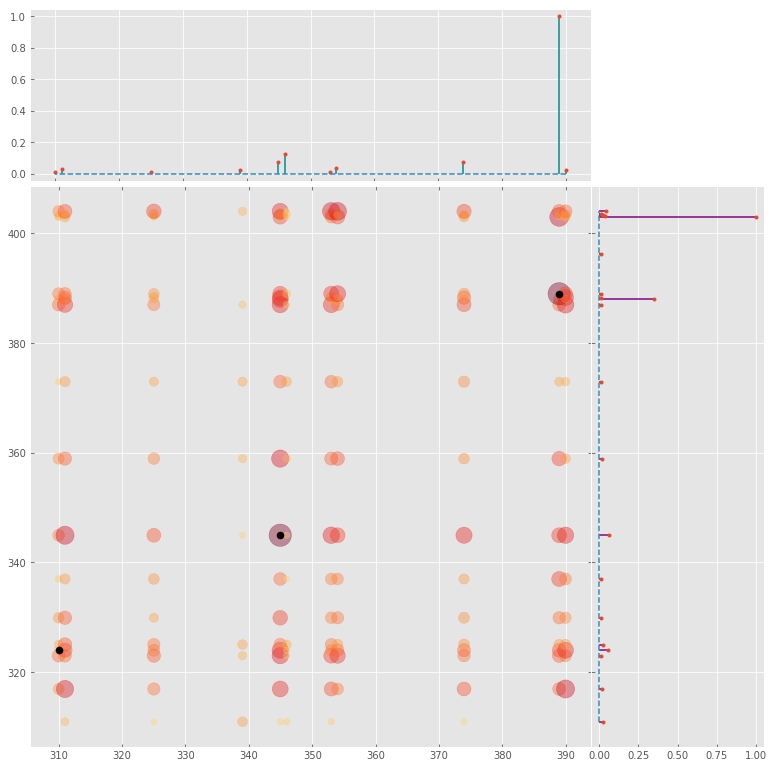

Scour processed file "draw_mols_temp.svg" in 37 ms: 8307/13613 bytes new/orig -> 61.0%


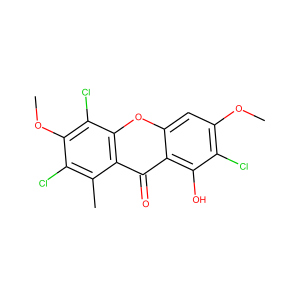

Scour processed file "draw_mols_temp.svg" in 72 ms: 8275/13693 bytes new/orig -> 60.4%


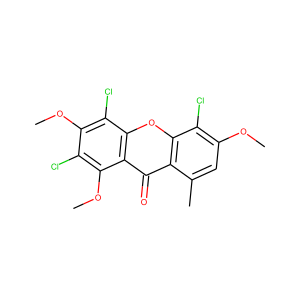

In [30]:
#similar cases: 10,11, 15, 20, 100, 500...
# other usually large molecule types: 200, 800, 1000, 1700, 2000, 2600, 3280
# smaller molecules: 2996, 2007, 3000, 3003, 3004, 3005, 3010
# Long chains: 3200, 3230 

id = 3011
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 300, 
                                                  max_mz = 800,
                                                  threshold = 0.01,
                                                  tol = 0.005,
                                                  method = 'modcos',
                                                  wordsim_cutoff = 0.25,
                                                  display_molecules = True)

303 291
Spec2Vec score:  0.9576214004700782
Cosine score:  0.055420545697188184
Modified cosine score:  0.06902653436065635
Molecular similarity:  0.8700284090909091
  Created documents for  2  of  2  spectra.

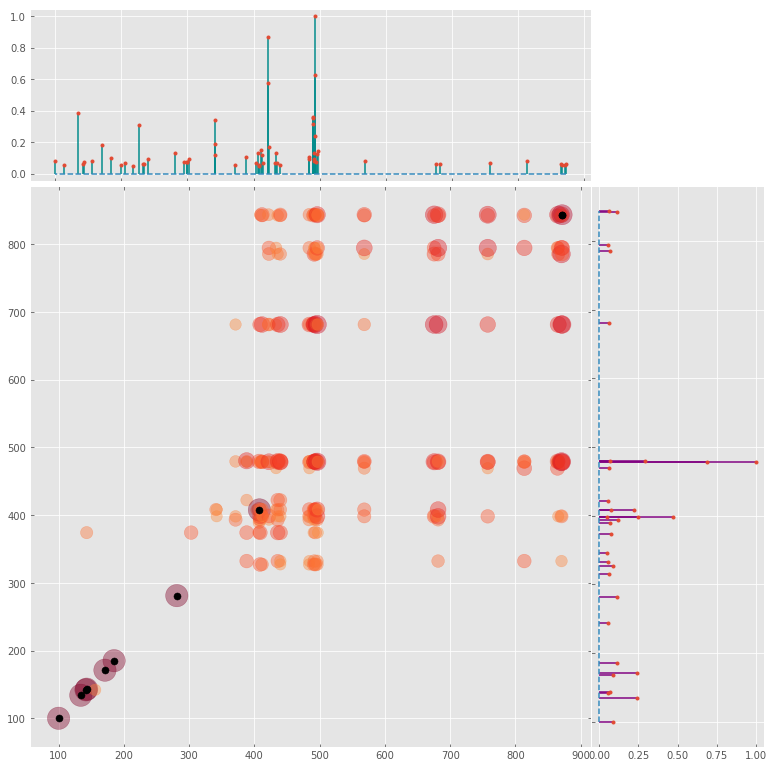

Scour processed file "draw_mols_temp.svg" in 122 ms: 17801/31122 bytes new/orig -> 57.2%


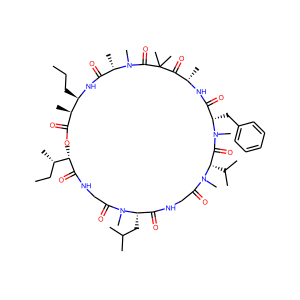

Scour processed file "draw_mols_temp.svg" in 91 ms: 17659/30922 bytes new/orig -> 57.1%


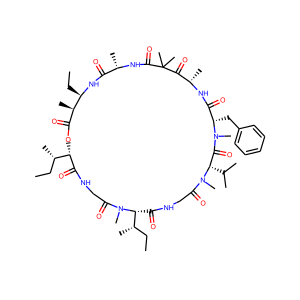

In [35]:
#similar cases: 10,11, 15, 20, 100, 500...
# other usually large molecule types: 200, 800, 1000, 1700, 2000, 2600, 3280
# smaller molecules: 2996, 2007, 3000, 3003, 3004, 3005, 3010
# Long chains: 3200, 3230 

id = 100
ID1, ID2 = pair_selection[0][id], pair_selection[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 1000,
                                                  threshold = 0.05,
                                                  tol = 0.005,
                                                  method = 'modcos',
                                                  wordsim_cutoff = 0.5,
                                                  display_molecules = True)

# Case 2:
## Example for: cosine=high, molnet=high, word2vec=low, molecular similarity=low

In [26]:
pair_selection2 = np.where((M_sim_cosine > 0.8)
                          & (M_sim_modcos >  0.9)
                & (M_sim_ctr < 0.3)  
                & (M_mol_sim_rdkit < 0.3))

print("Found ", pair_selection2[0].shape, " matching spectral pairs.")

Found  (276,)  matching spectral pairs.


3293 2848
Spec2Vec score:  0.25607232441369765
Cosine score:  0.9817221602495751
Modified cosine score:  0.9818441534294207
Molecular similarity:  0.26405693950177933
  Created documents for  2  of  2  spectra.

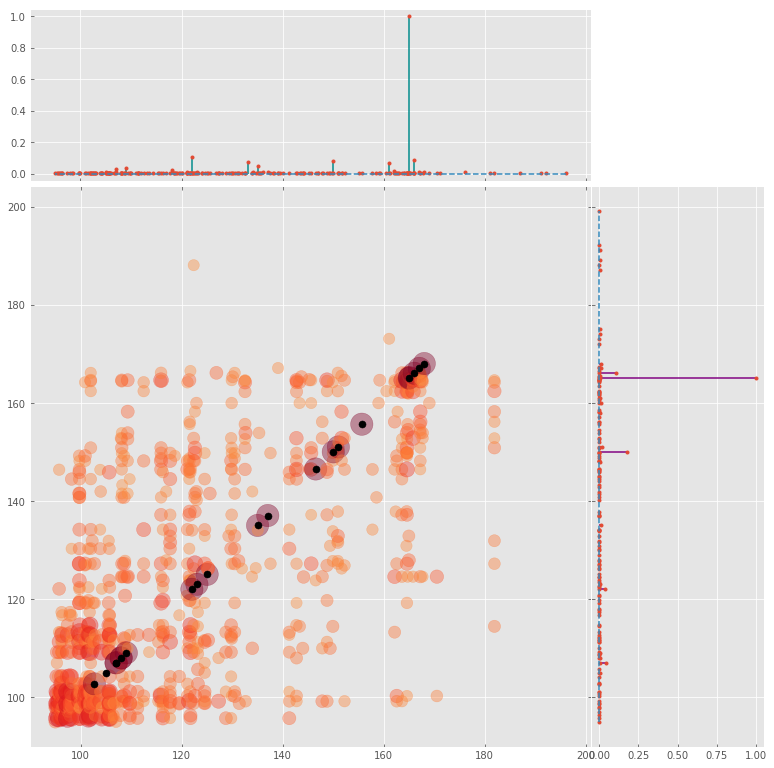

Scour processed file "draw_mols_temp.svg" in 32 ms: 5875/9999 bytes new/orig -> 58.8%


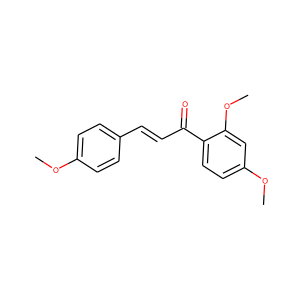

Scour processed file "draw_mols_temp.svg" in 129 ms: 10455/17219 bytes new/orig -> 60.7%


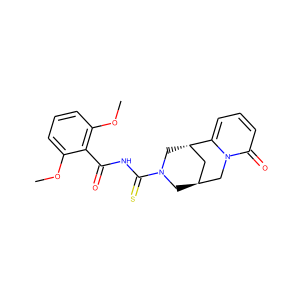

In [27]:
id = 50 #40
ID1, ID2 = pair_selection2[0][id], pair_selection2[1][id]
print(ID1, ID2)
print("Spec2Vec score: ", M_sim_ctr[ID1, ID2])
print("Cosine score: ", M_sim_cosine[ID1, ID2])
print("Modified cosine score: ", M_sim_modcos[ID1, ID2])
print("Molecular similarity: ", M_mol_sim_rdkit[ID1, ID2])

Csim_words = plot_spectra_comparison(MS_library,
                                                  spectra,
                                                  2,
                                                  ID1, ID2, 
                                                  min_mz = 0, 
                                                  max_mz = 200,
                                                  threshold = 0.001,
                                                  tol = 0.005,
                                                  method = 'modcos',
                                                  wordsim_cutoff = 0.5,
                                                  display_molecules = True)